In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import copy
import sys
from math import sqrt
%matplotlib inline
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

### 1. Классификация. Анализ стоит ли давать кредит человеку основываясь на параметрах.

In [2]:
data = pd.read_csv("customer_data.csv")
data2 = pd.read_csv("payment_data.csv")
data.shape, data2.shape

((1125, 13), (8250, 12))

In [3]:
data = pd.merge(data, data2, left_on='id', right_on='id', how='left').drop('id', axis=1)

In [4]:
data.columns

Index(['label', 'fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7',
       'fea_8', 'fea_9', 'fea_10', 'fea_11', 'OVD_t1', 'OVD_t2', 'OVD_t3',
       'OVD_sum', 'pay_normal', 'prod_code', 'prod_limit', 'update_date',
       'new_balance', 'highest_balance', 'report_date'],
      dtype='object')

In [5]:
data = data.drop(columns=['report_date','prod_limit','update_date','OVD_t1'])

In [6]:
data = data.drop(columns=['OVD_t2','OVD_t3','OVD_sum','new_balance','highest_balance'])

In [7]:
data.shape

(8250, 14)

### 2. Препроцессинг данных

In [8]:
data.columns

Index(['label', 'fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7',
       'fea_8', 'fea_9', 'fea_10', 'fea_11', 'pay_normal', 'prod_code'],
      dtype='object')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8250 entries, 0 to 8249
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   label       8250 non-null   int64  
 1   fea_1       8250 non-null   int64  
 2   fea_2       7222 non-null   float64
 3   fea_3       8250 non-null   int64  
 4   fea_4       8250 non-null   float64
 5   fea_5       8250 non-null   int64  
 6   fea_6       8250 non-null   int64  
 7   fea_7       8250 non-null   int64  
 8   fea_8       8250 non-null   int64  
 9   fea_9       8250 non-null   int64  
 10  fea_10      8250 non-null   int64  
 11  fea_11      8250 non-null   float64
 12  pay_normal  8250 non-null   int64  
 13  prod_code   8250 non-null   int64  
dtypes: float64(3), int64(11)
memory usage: 966.8 KB


In [10]:
mean = data['fea_2'].mean()
std = data['fea_2'].std() # стандартное отклонение
number_of_nulls = data['fea_2'].isnull().sum()
random_v = np.random.randint(mean - std, mean + std, size=number_of_nulls)

In [11]:
new_v = data['fea_2'].copy()
new_v[np.isnan(new_v)] = random_v
data['fea_2'] = new_v

In [12]:
data.head()

,label,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,pay_normal,prod_code
0,1,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974,9,10
1,1,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974,18,10
2,1,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974,1,5
3,1,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974,6,10
4,0,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840,4,6


### 2*. Посмотрим на корреляцию данных.

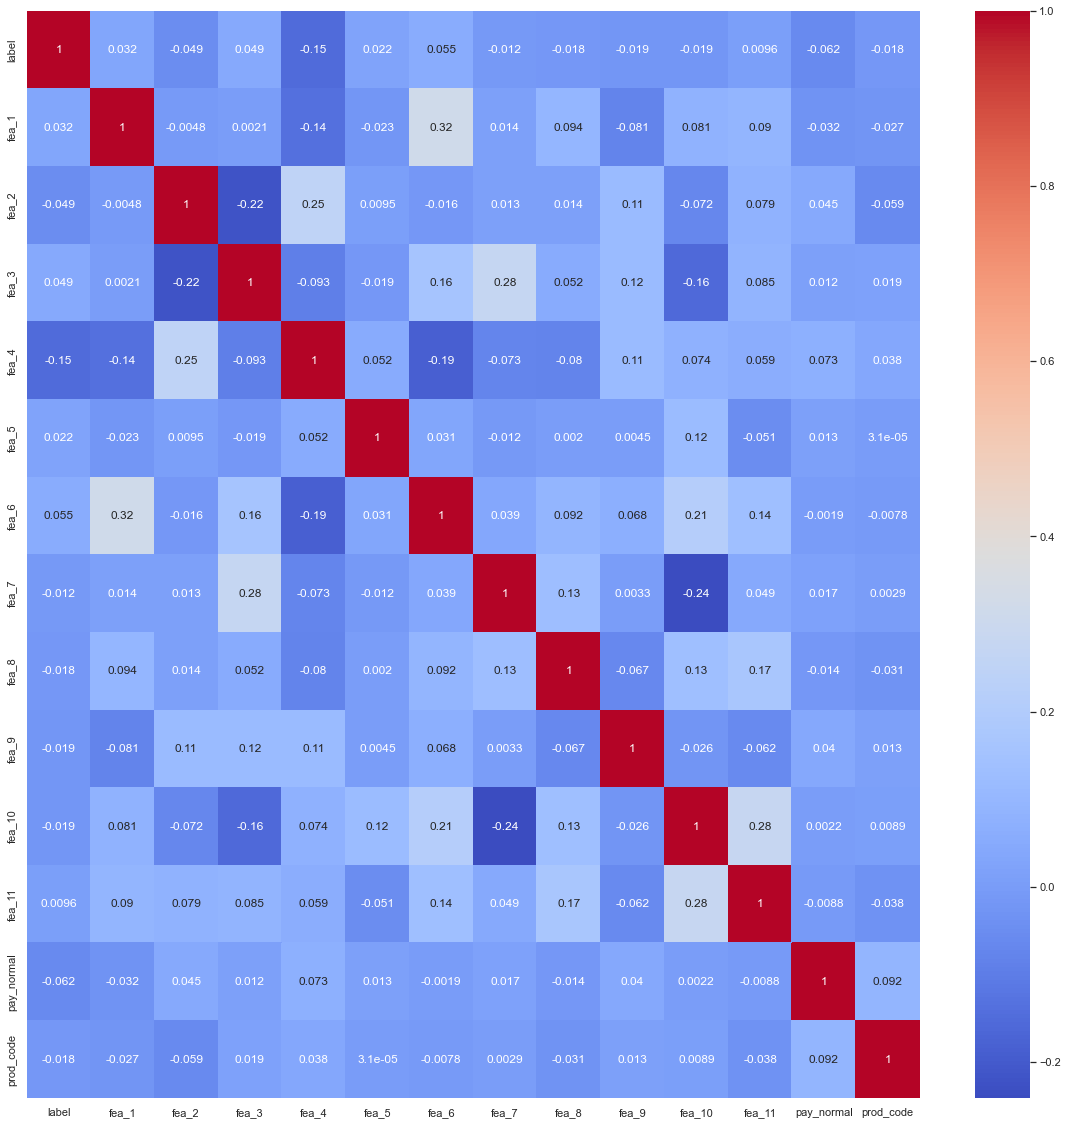

In [13]:
figure = plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
None

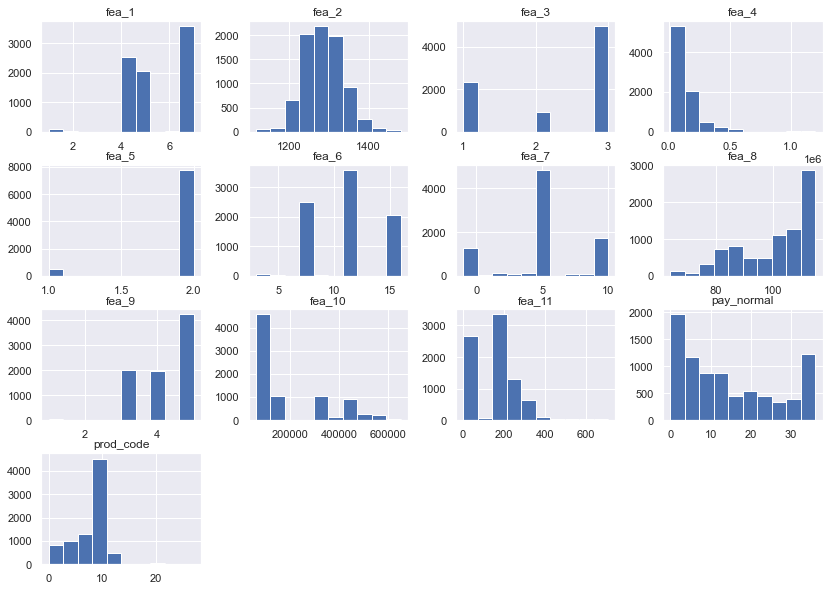

In [14]:
data.hist(column=data.columns[1:], figsize=(14, 10))
None

### 3. Реализация метрики качества. \\ аргументировать выбор метрики качества 

Так как у нас всего два класса, используем оценки качества precision и recall, но нам надо обьеденить их в одну, поэтому используем новое выражение называемое F-мерой, который считается как 
```(1 + betta**2) * (precision * recall) / ((betta**2 * precision) + recall)```

In [15]:
def F(x, y, betta=1):
    TP = sum([x[i] == 1 and y[i] == 1 for i in range(len(x))])
    FP = sum([x[i] == 1 and y[i] == 0 for i in range(len(x))])
    FN = sum([x[i] == 0 and y[i] == 1 for i in range(len(x))])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return (1 + betta**2) * (precision * recall) / ((betta**2 * precision) + recall)

In [16]:
indicators = data.columns[1:]
target_columns = data.columns[0]

In [17]:
X = data[indicators]
y = data[target_columns]

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size=0.2)

### Реализация Standart Scaller

In [19]:
def scaller(data):
    data = data.transpose()
    for row in data:
        avg = sum([x for x in row]) / len(row)
        dist = sqrt(sum([(x-avg)**2 for x in row]) / len(row))
        for i in range(len(row)):
            row[i] = (row[i] - avg) / dist
    return data.transpose()

In [20]:
X_scalled = scaller(X.to_numpy())
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_scalled, y, test_size=0.2)
X_train_S.shape, X_test_S.shape, y_train_S.shape, y_test_S.shape

((6600, 13), (1650, 13), (6600,), (1650,))

### 4. Реализовать и обучить логистическую регрессию или линейную регрессию \\ !!!не разрешается использовать sklearn!!!

In [21]:
class LR:
    def __init__(self, step=10**-2, it_c=100):
        self.step = step
        self.it_c = it_c

    def get_coeff(self, x, y):
        return self.err(x, y.values.ravel())
    
    def err(self, x, y):
        p = [self.predict(i) for i in x]
        return sum(p==y) / len(y)
    
    def reg(self):
        return 0
    
    def fit(self, x, y):
        y = y.to_numpy()
        np.c_[x, np.ones(len(x))]
        self.w = np.zeros(x.shape[1])
        f, h = [], []
        for i in range(self.it_c):
            z = [sum([x[i][j]*self.w[j] for j in range(len(x[i]))]) for i in range(len(x))]
            res = np.array([1 / (1 + np.exp(-a)) for a in z])
            grad = np.dot(x.T, res - y) / y.size
            self.w -= self.step * grad - self.reg()
            h.append(self.err(x, y))
            f.append(F(self.predict(x), y))
        return h, f
            
    def predict(self, x):
        np.append(x,1)
        return (1 / (1 + np.exp(-np.dot(x, self.w)))).round()
    
    def F_mera(self, x, y):
        f(x,y)

### 4*. Добавить регуляризацию \\ не разрешается использовать sklearn

In [45]:
class LRreg(LR):
    def __init__(self, step=10**-2, it_c=100, L=None, alpha=0.00001):
        self.step = step
        self.it_c = it_c
        self.L = L
        self.alpha = alpha
        
    def reg(self):
        if self.L == 'L1':
            return self.alpha * sum([abs(i) for i in self.w])
        elif self.L == 'L2':
            return self.alpha * sum([i**2 for i in self.w])
        else:
            return 0

### 5. Оценить качество модели на обучающей и тестовой выборках \\ не разрешается использовать sklearn

### Сначала обучим на наших данных

In [ ]:
mlg = LR()
hist, f = mlg.fit(X_train, y_train)
print(f"\nmy LogReg: {mlg.get_coeff(X_test, y_test)}")

In [ ]:
mlgL1 = LRreg(L='L1')
histL1, fL1 = mlgL1.fit(X_train, y_train)
print(f"\nmy LogReg L1: {mlgL1.get_coeff(X_test, y_test)}")

In [ ]:
mlgL2 = LRreg(L='L2')
histL2, fL2 = mlgL2.fit(X_train, y_train)
print(f"\nmy LogReg L2: {mlgL2.get_coeff(X_test, y_test)}")

### А потом на нормированных

In [26]:
mlg = LR()
hist_S, f_S = mlg.fit(X_train_S, y_train_S)
print(f"\nmy LogReg: {mlg.get_coeff(X_test_S, y_test_S)}")


my LogReg: 0.49575757575757573


In [27]:
mlgL1 = LRreg(L='L1')
histL1_S, fL1_S = mlgL1.fit(X_train_S, y_train_S)
print(f"\nmy LogReg L1: {mlgL1.get_coeff(X_test_S, y_test_S)}")


my LogReg L1: 0.49575757575757573


In [28]:
mlgL2 = LRreg(L='L2')
histL2_S, fL2_S = mlgL2.fit(X_train_S, y_train_S)
print(f"\nmy LogReg L2: {mlgL2.get_coeff(X_test_S, y_test_S)}")


my LogReg L2: 0.49575757575757573


### 5*. Сделать график ошибки модели на обучающей и тестовой выборках 
### 5*. Сделать график точности модели на обучающей и тестовой выборках

#### График точности моделей для всех регулязациях (без нее, L1, L2)

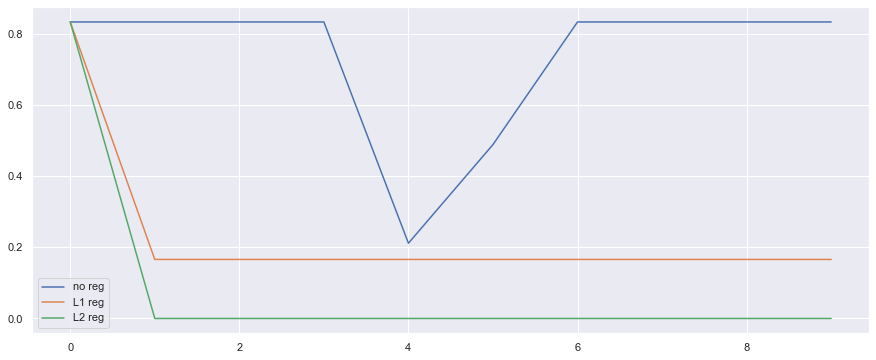

In [43]:
figure = plt.figure(figsize=(15,6))
plt.plot(hist[::10], label="no reg")
plt.plot(histL1[::10], label="L1 reg")
plt.plot(histL2[::10], label="L2 reg")
plt.legend()
plt.show()

#### График метрики моделей для всех регулязациях (без нее, L1, L2) чем больше тем лучше

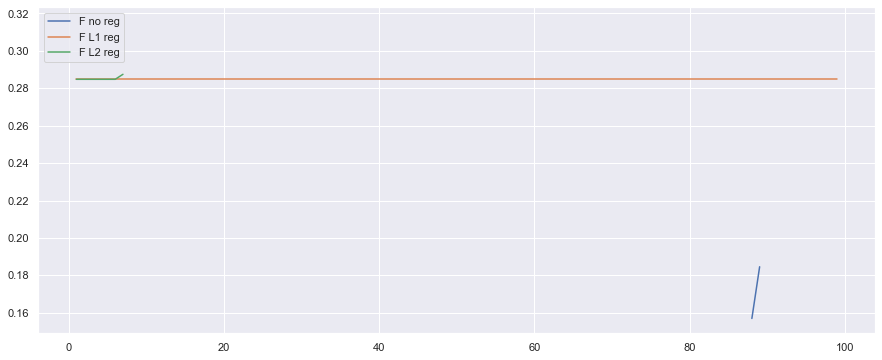

In [44]:
figure = plt.figure(figsize=(15,6))
plt.plot(f[::], label="F no reg")
plt.plot(fL1[::], label="F L1 reg")
plt.plot(fL2[::], label="F L2 reg")
plt.legend()
plt.show()

### А потом граффики нормированных

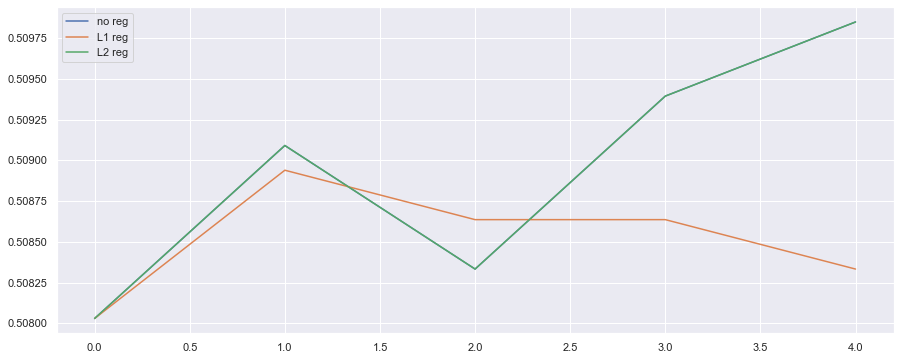

In [31]:
figure = plt.figure(figsize=(15,6))
plt.plot(hist_S[::20], label="no reg")
plt.plot(histL1_S[::20], label="L1 reg")
plt.plot(histL2_S[::20], label="L2 reg")
plt.legend()
plt.show()

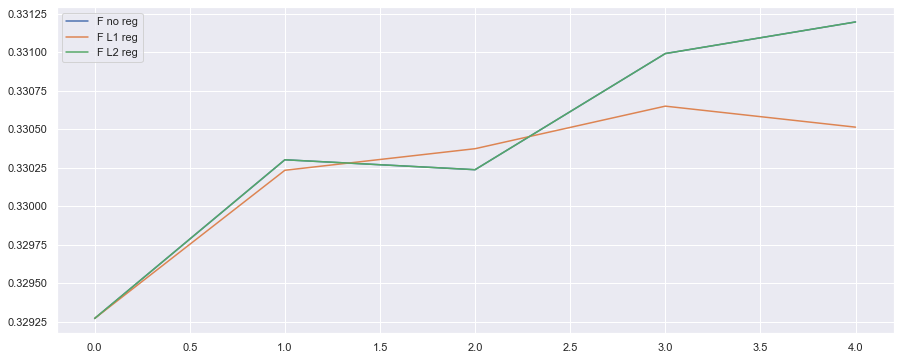

In [32]:
figure = plt.figure(figsize=(15,6))
plt.plot(f_S[::20], label="F no reg")
plt.plot(fL1_S[::20], label="F L1 reg")
plt.plot(fL2_S[::20], label="F L2 reg")
plt.legend()
plt.show()

### 6. Обучить логистическую регрессию или линейную регрессию из sklearn, оценить качество модели на обучающей и тестовой выборках и сравнить со своей моделью

In [33]:
from sklearn.linear_model import LogisticRegression
sklg = LogisticRegression(max_iter=1400)
sklg.fit(X_train, y_train.values.ravel())
print(f"sklearn: {sklg.score(X_test, y_test.values.ravel())}")

sklearn: 0.8236363636363636


### 6*. Сделать график ошибки модели из sklearn на обучающей и тестовой выборках и сравнить со своей моделью
### 6*. Сделать график точности модели из sklearn на обучающей и тестовой выборках и сравнить со своей моделью

In [34]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(
    LogisticRegression(max_iter=1400), X_train, y_train.values.ravel(), cv=5)

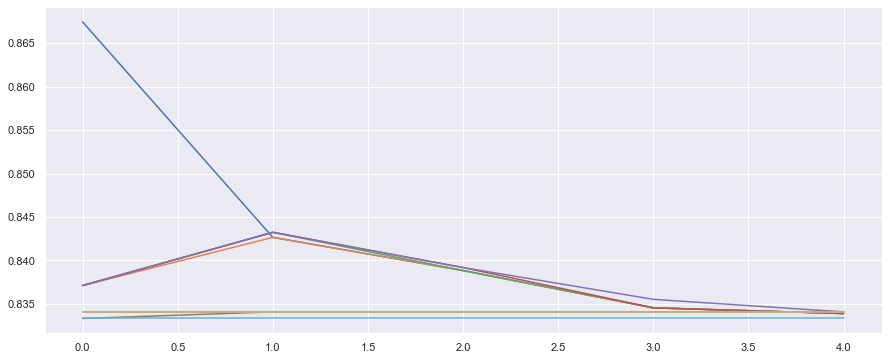

In [35]:
figure = plt.figure(figsize=(15,6))
plt.plot(train_scores)
plt.plot(valid_scores)
plt.show()